In [1]:
#push!(LOAD_PATH, "/Users/clau/PBJ/src/base/")
#push!(LOAD_PATH, "/src/base/")
push!(LOAD_PATH, "/Users/clau/PBJ/")
#> PBJ Modules
using ParticlesModule
using GridModule
using ParticleGridInteractionModule
using UnitsModule
using FieldModule

#> Julia Plotting Modules
using Plots
using Plots.PlotMeasures

#> Extendable arrays module
using ElasticArrays

#> FileIO Module
using HDF5,JLD

In [2]:
# #> Number of snapshots made
# N_snapshot_steps = 1000
# #> Number of steps made
# N_steps = 190000
#> Number of snapshots made
N_snapshot_steps = 100
#> Number of steps made
N_steps = 30000
#> Number of skips for gif making
N_skip = Int(round(N_steps/N_snapshot_steps))


300

In [3]:
temperature = 2.2
density = 5.0e13
units=UnitsModule.SetUnits(density,temperature)
println("Normalized Epsilon0:",units.norm_permittivity)
println("Unit Length:",units.unit_length)
println("Unit Velocity:",units.unit_velocity)
println("Unit Time:",units.unit_time)

Normalized Epsilon0:189554.76269104556
Unit Length:0.001559270869791819
Unit Velocity:622011.0478385943
Unit Time:2.50682182448379e-9


In [4]:
#> Simulation parameters in SI units

#> [grid cells]
N_x = 100

#> Particles per cell
electron_ppc = 1000
ion_ppc = 100

#> [m]
L_x = 0.04 

#> [s]
dt = 1.3e-10

#> [m]
dx = L_x/N_x

#> [V]
phi_left_boundary = 12.5
phi_right_boundary = 0.0

#> Injection zone buffer fraction
injection_zone_buffer_fraction = 0.01

#> [eV]
ion_temperature = 0.5
electron_temperature = 2.2

#> [electron mass]
#ion_mass = 39.9*1836.0
ion_mass = 1836.0
electron_mass = 1.0

#> [electron charge]
ion_charge = 1.0
electron_charge = -1.0

#> [m/s]
ion_thermal_velocity = UnitsModule.GetThermalVelocity(
    ion_temperature,ion_mass*units.unit_mass
)
electron_thermal_velocity = UnitsModule.GetThermalVelocity(
    electron_temperature,electron_mass*units.unit_mass
)

#> [m^-3]
ion_density = 5.0e13
electron_density = 5.0e13

5.0e13

In [5]:
#> Normalize to simulation units
struct Parameters
    dt :: Float64
    dx :: Float64
    L_x :: Float64
    N_x :: Int
    #> ion species
    ion_ppc :: Int
    ion_temperature :: Float64
    ion_density :: Float64
    ion_mass :: Float64
    ion_charge :: Float64
    ion_thermal_velocity :: Float64
    ion_particle_shape_x :: Float64
    #> electron species
    electron_ppc :: Int
    electron_temperature :: Float64
    electron_density :: Float64
    electron_mass :: Float64
    electron_charge :: Float64
    electron_thermal_velocity :: Float64
    electron_particle_shape_x :: Float64
    #> miscellany
    phi_left_boundary :: Float64
    phi_right_boundary :: Float64
    injection_zone_buffer_fraction :: Float64
end

Simulation_Parameters=Parameters(
    dt/units.unit_time,
    dx/units.unit_length,
    L_x/units.unit_length,
    N_x,
    ion_ppc,
    ion_temperature/units.unit_temperature,
    ion_density/units.unit_density,
    ion_mass,
    ion_charge,
    ion_thermal_velocity/units.unit_velocity,
    (dx/units.unit_length)*0.5,
    
    electron_ppc,
    electron_temperature/units.unit_temperature,
    electron_density/units.unit_density,
    electron_mass,
    electron_charge,
    electron_thermal_velocity/units.unit_velocity,
    (dx/units.unit_length)*0.5,
    
    phi_left_boundary/units.unit_potential,
    phi_right_boundary/units.unit_potential,
    injection_zone_buffer_fraction
)

function Initialize(sim_params)
    #> Initialize the mesh
    grid=GridModule.GridArrayInit(
        sim_params.N_x+1,0.0,sim_params.L_x,
        5,0.0,1.0,
        5,0.0,1.0
    )
    vlim=3
    vgrid=GridModule.GridArrayInit(
        101,-vlim,vlim,
        5,-vlim,vlim,
        5,-vlim,vlim,
    )
    #> Initialize the particles
    electrons=ParticlesModule.ParticleInjectionFromLeft_Init(
        grid,sim_params.electron_density;
        particles_per_cell=sim_params.electron_ppc,
        mass=sim_params.electron_mass,
        charge=sim_params.electron_charge,
        vx_thermal_speed=sim_params.electron_thermal_velocity,
        vy_thermal_speed=sim_params.electron_thermal_velocity,
        vz_thermal_speed=sim_params.electron_thermal_velocity,
        particle_shape_x=sim_params.electron_particle_shape_x,
        buffer_fraction=sim_params.injection_zone_buffer_fraction,
        time_step=sim_params.dt
    );
    ions=ParticlesModule.ParticleInjectionFromLeft_Init(
        grid,sim_params.ion_density;
        particles_per_cell=sim_params.ion_ppc,
        mass=sim_params.ion_mass,
        charge=sim_params.ion_charge,
        vx_thermal_speed=sim_params.ion_thermal_velocity,
        vy_thermal_speed=sim_params.ion_thermal_velocity,
        vz_thermal_speed=sim_params.ion_thermal_velocity,
        particle_shape_x=sim_params.ion_particle_shape_x,
        buffer_fraction=sim_params.injection_zone_buffer_fraction,
        time_step=sim_params.dt
    );
    #> Initialize the Fields struct
    Fields_struct=FieldModule.Fields_Init(grid)
    
    #> Initialize the Poisson struct
    Poisson_struct=FieldModule.Poisson_1D_Init(
        grid.x,sim_params.phi_left_boundary,sim_params.phi_right_boundary
    )
    return grid,vgrid,Fields_struct,Poisson_struct,ions,electrons
end
grid,vgrid,Fields_struct,Poisson_struct,ions,electrons=Initialize(Simulation_Parameters)

avg_field_struct=FieldModule.Fields_Init(grid)

println("N_e,0:",electrons.number_particles)
println("N_i,0:",ions.number_particles)

println("dt:",dt)
println("dx:",dx)
println("L_x:",L_x)
println("ne:",electron_density)
println("ni:",ion_density)
println("v_the:",electron_thermal_velocity)
println("v_thi:",ion_thermal_velocity)

N_e,0:1000
N_i,0:100
dt:1.3e-10
dx:0.0004
L_x:0.04
ne:5.0e13
ni:5.0e13
v_the:622011.0478385943
v_thi:6920.467314367994


N_electrons:1000
N_ions:100


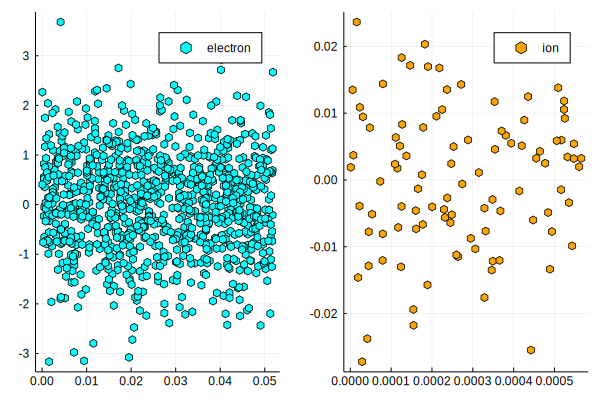

In [6]:
pe_x = fill(0.0,electrons.number_particles)
pe_vx = fill(0.0,electrons.number_particles)
pe_f_over_g = fill(0.0,electrons.number_particles)

for ip in 1:electrons.number_particles
    pe_x[ip]=electrons.particle[ip].x
    pe_vx[ip]=electrons.particle[ip].vx
    pe_f_over_g[ip]=electrons.particle[ip].f_over_g
end

pi_x = fill(0.0,ions.number_particles)
pi_vx = fill(0.0,ions.number_particles)
pi_f_over_g = fill(0.0,ions.number_particles)

for ip in 1:ions.number_particles
    pi_x[ip]=ions.particle[ip].x
    pi_vx[ip]=ions.particle[ip].vx
    pi_f_over_g[ip]=ions.particle[ip].f_over_g
end
println("N_electrons:",electrons.number_particles)
println("N_ions:",ions.number_particles)
plot(
    scatter(
        pe_x,pe_vx,
        marker=:hexagon,
        color=:cyan,
        label="electron"
    ),
    scatter(
        pi_x,pi_vx,
        marker=:hexagon,
        color=:orange,
        label="ion",

    ),
        layout=(1,2)
)

In [7]:
if(false)
    anim = @animate for i in 1:20000

        #> Inject new particles
        Ne_current=electrons.number_particles
        ParticlesModule.ParticleInjectionFromLeft_Continue!(
            electrons,grid,electron_density,
            particles_per_cell=electron_ppc,
            vx_thermal_speed=electron_thermal_velocity,
            vy_thermal_speed=electron_thermal_velocity,
            vz_thermal_speed=electron_thermal_velocity,
            time_step=dt,
            buffer_multiplier=20
        );
        Ne_post_injection=electrons.number_particles

        #> Inject new particles
        Ni_current=ions.number_particles
        ParticlesModule.ParticleInjectionFromLeft_Continue!(
            ions,grid,ion_density,
            particles_per_cell=ion_ppc,
            vx_thermal_speed=ion_thermal_velocity,
            vy_thermal_speed=ion_thermal_velocity,
            vz_thermal_speed=ion_thermal_velocity,
            time_step=dt,
            buffer_multiplier=200
        );
        Ni_post_injection=ions.number_particles

        #> Push particles
        ParticlesModule.UpdateParticlePosition!(electrons)
        ParticlesModule.UpdateParticleVelocity!(electrons)
        ParticlesModule.UpdateParticlePosition!(ions)
        ParticlesModule.UpdateParticleVelocity!(ions)

        #> Apply the left/right hand side boundary
        ParticleGridInteractionModule.ApplyAbsorptionParticleBoundary_LeftRight!(
            electrons,
            grid
        )
        Ne_post_absorption=electrons.number_particles
        ParticleGridInteractionModule.ApplyAbsorptionParticleBoundary_LeftRight!(
            ions,
            grid
        )
        Ni_post_absorption=ions.number_particles

        append!(Ne_markers,[electrons.number_particles])
        append!(Ne_array,[length(electrons.particle)])
        append!(Ne_injected,[Ne_post_injection-Ne_current])
        append!(Ne_absorbed,[Ne_post_absorption-Ne_post_injection])
        append!(Ne_changed,[Ne_post_absorption-Ne_current])

        append!(Ni_markers,[ions.number_particles])
        append!(Ni_array,[length(ions.particle)])
        append!(Ni_injected,[Ni_post_injection-Ni_current])
        append!(Ni_absorbed,[Ni_post_absorption-Ni_post_injection])
        append!(Ni_changed,[Ni_post_absorption-Ni_current])

        append!(i_step,[i])

        pe_x = fill(0.0,electrons.number_particles);
        pe_vx = fill(0.0,electrons.number_particles);
        for ip in 1:electrons.number_particles;
            pe_x[ip]=electrons.particle[ip].x;
            pe_vx[ip]=electrons.particle[ip].vx;
        end;

        pi_x = fill(0.0,ions.number_particles);
        pi_vx = fill(0.0,ions.number_particles);
        for ip in 1:ions.number_particles;
            pi_x[ip]=ions.particle[ip].x;
            pi_vx[ip]=ions.particle[ip].vx;
        end;

        plot(
            scatter(
                pe_x,pe_vx,
                marker=:hexagon,
                markeralpha = 0.1,
                label="electron"
            ),
            plot(
                i_step[1,1:end],Ne_markers[1,1:end],
                label="electrons"
            ),    
            plot(
                i_step[1,1:end],Ne_injected[1,1:end],
                label="injected electrons"
            ),    
            layout=(1,3),
            size=(1600,600)
        )

        scatter!(
            pi_x,pi_vx,
            marker=:hexagon,
            markeralpha = 0.1,
            label="ion",
            sp=1
        )

        plot!(
            i_step[1,1:end],Ni_markers[1,1:end],
            label="ions",
            sp=2
        )  

        plot!(
            i_step[1,1:end],Ni_injected[1,1:end],
            label="injected ions",
            sp=3
        )

        plot!(
            sp=1,
            ylims=(minimum(vgrid.x)-0.1,maximum(vgrid.x)+0.1), 
            xlims=(minimum(grid.x)-0.1,maximum(grid.x)+0.1), 
            frame=:zerolines,
            ylabel="vx", xlabel="x",
            #legend=:outertop,
            foreground_color_legend = nothing,
            margin=20px
        )


        plot!(
            sp=2,
            i_step[1,1:end],Ne_array[1,1:end],
            label="electron array size"
        )

        plot!(
            sp=2,
            i_step[1,1:end],Ni_array[1,1:end],
            label="ion array size"
        )

        plot!(
            sp=2,
            xlabel="time-steps",
            frame=:zerolines,
            legend=:bottomright,foreground_color_legend = nothing,
            margin=20px
        )


        plot!(
            sp=3,
            i_step[1,1:end],Ne_absorbed[1,1:end],
            label="absorbed electrons"
        )

        plot!(
            sp=3,
            i_step[1,1:end],Ni_absorbed[1,1:end],
            label="absorbed ions"
        )


        plot!(
            sp=3,
            i_step[1,1:end],Ne_changed[1,1:end],
            label="change in electrons"
        )   

        plot!(
            sp=3,
            i_step[1,1:end],Ni_changed[1,1:end],
            label="change in ions"
        )   

        plot!(
            sp=3,
            #ylim=(-50,50),
            frame=:zerolines,
            ylabel="N particles", xlabel="time-steps",
            #legend=:inside,
            foreground_color_legend = nothing,
            #legendfontsize=5,
            margin=20px
        )

        end every 50
end

In [8]:
if(false)
    fps=30
    gif(anim, "ion_electron_flow_fps="*string(fps)*".gif", fps = fps)
end

In [9]:
function Calculate_Electrostatic_Potential(
        fields_struct,poisson_struct,ions,electrons,grid,
        sim_params,
        units
    )
    #> Scatter ion density
    ion_density = ParticleGridInteractionModule.ScatterParticleToGrid_x(
        ions,grid
    );
#     ion_density = ParticleGridInteractionModule.ApplyFiniteParticleShape_x(
#         ion_density,ions,grid,sim_params.ion_density,0.0
#     );
    ion_density = ParticleGridInteractionModule.ApplyFiniteParticleShape_x_121(
        2,ion_density,ions,grid#,sim_params.ion_density,0.0
    );
    #> Divide by the cell size. The ends are half-cells.
    ion_density ./= grid.x[2]-grid.x[1]
    ion_density[1] *= 2.0
    ion_density[end] *= 2.0
#     #> Boundary enforcement, the right boundary density goes to 0 (all escape/absorbed)
#     ion_density[end] = 0.0
#     #> Boundary enforcement, the left boundary density goes to eq density
#     ion_density[1] = sim_params.ion_density
    
    #> Scatter electron density
    electron_density = ParticleGridInteractionModule.ScatterParticleToGrid_x(
        electrons,grid
    );
#     electron_density = ParticleGridInteractionModule.ApplyFiniteParticleShape_x(
#         electron_density,electrons,grid,sim_params.electron_density,0.0
#     );
    electron_density = ParticleGridInteractionModule.ApplyFiniteParticleShape_x_121(
         2,electron_density,electrons,grid#,sim_params.electron_density,0.0
     );
    #> Divide by the cell size. The ends are half-cells.
    electron_density ./= grid.x[2]-grid.x[1]
    electron_density[1] *= 2.0
    electron_density[end] *= 2.0
#     #> Boundary enforcement, the right boundary density goes to 0 (all escape/absorbed)
#     electron_density[end] = 0.0
#     #> Boundary enforcement, the left boundary density goes to eq density
#     electron_density[1] = sim_params.electron_density
    
    phi=FieldModule.Poisson_1D_Solve(
        poisson_struct,
        (ion_density.-electron_density)
    );
    fields_struct.phi[1:end]=phi[1:end]
    fields_struct.electron_density[1:end]=electron_density[1:end]
    fields_struct.ion_density[1:end]=ion_density[1:end]
end

function Inject_Particles!(ions,electrons,sim_params)
        #> Inject new particles
        ParticlesModule.ParticleInjectionFromLeft_Continue!(
            electrons,grid,sim_params.electron_density,
            particles_per_cell=sim_params.electron_ppc,
            vx_thermal_speed=sim_params.electron_thermal_velocity,
            vy_thermal_speed=sim_params.electron_thermal_velocity,
            vz_thermal_speed=sim_params.electron_thermal_velocity,
            time_step=sim_params.dt,
            buffer_fraction=sim_params.injection_zone_buffer_fraction,
            buffer_multiplier=20
        );
        
        #> Inject new particles
        ParticlesModule.ParticleInjectionFromLeft_Continue!(
            ions,grid,sim_params.ion_density,
            particles_per_cell=sim_params.ion_ppc,
            vx_thermal_speed=sim_params.ion_thermal_velocity,
            vy_thermal_speed=sim_params.ion_thermal_velocity,
            vz_thermal_speed=sim_params.ion_thermal_velocity,
            time_step=sim_params.dt,
            buffer_fraction=sim_params.injection_zone_buffer_fraction,
            buffer_multiplier=200
        );
end

function Field_to_Particles!(fields_struct,ions,electrons,grid)
    #> Calculate the electric field from electrostatic potential
#     electric_field_x = FieldModule.CalculateElectricField_FD_1D_conducting_boundaries(
#         fields_struct.phi,grid
#     )
    electric_field_x = FieldModule.CalculateElectricField_FD_1D(
        fields_struct.phi,grid
    )
    #> Scatter field to particles
    ParticleGridInteractionModule.ScatterFieldToParticle_Ex!(
        electric_field_x,electrons,grid
    )         
    ParticleGridInteractionModule.ScatterFieldToParticle_Ex!(
        electric_field_x,ions,grid
    )         
end

function Push_Particles!(ions,electrons,grid,sim_params)
    #> Push particles
    ParticlesModule.UpdateParticlePosition!(electrons)
    ParticlesModule.UpdateParticleVelocity!(electrons)
    ParticlesModule.UpdateParticlePosition!(ions)
    ParticlesModule.UpdateParticleVelocity!(ions)
    #> Apply the left/right hand side boundary
    ParticleGridInteractionModule.ApplyAbsorptionParticleBoundary_LeftRight!(
        electrons,
        grid
    )
    ParticleGridInteractionModule.ApplyAbsorptionParticleBoundary_LeftRight!(
        ions,
        grid
    )
#     #> Apply right hand side absorbing boundary
#     ParticleGridInteractionModule.ApplyAbsorptionParticleBoundary_Right!(
#         electrons,
#         grid
#     )
#     ParticleGridInteractionModule.ApplyAbsorptionParticleBoundary_Right!(
#         ions,
#         grid
#     )
#     #> Apply left hand side reflux boundary
#     ParticleGridInteractionModule.ApplyRefluxParticleBoundary_Left!(
#         ions,
#         grid, 
#         sim_params.ion_thermal_velocity,
#         sim_params.ion_thermal_velocity,
#         sim_params.ion_thermal_velocity,
#     )
#     ParticleGridInteractionModule.ApplyRefluxParticleBoundary_Left!(
#         electrons,
#         grid, 
#         sim_params.electron_thermal_velocity,
#         sim_params.electron_thermal_velocity,
#         sim_params.electron_thermal_velocity,
#     )
end


Push_Particles! (generic function with 1 method)

In [10]:
Ne_markers = ElasticArray{Int}(undef, 1, 0)
Ne_array = ElasticArray{Int}(undef, 1, 0)
Ne_injected = ElasticArray{Int}(undef, 1, 0)
Ne_absorbed = ElasticArray{Int}(undef, 1, 0)
Ne_changed = ElasticArray{Int}(undef, 1, 0)

Ni_markers = ElasticArray{Int}(undef, 1, 0)
Ni_array = ElasticArray{Int}(undef, 1, 0)
Ni_injected = ElasticArray{Int}(undef, 1, 0)
Ni_absorbed = ElasticArray{Int}(undef, 1, 0)
Ni_changed = ElasticArray{Int}(undef, 1, 0)

i_step = ElasticArray{Int}(undef, 1, 0)

1×0 ElasticArray{Int64,2,1}

In [11]:
#> Initial calculation step

Calculate_Electrostatic_Potential(
    Fields_struct,Poisson_struct,ions,electrons,grid,Simulation_Parameters,units
    );
phi0=copy(Fields_struct.phi)
avg_field_struct.phi[:] = Fields_struct.phi[:]
avg_field_struct.ion_density[:] = Fields_struct.ion_density[:]
avg_field_struct.electron_density[:] = Fields_struct.electron_density[:]
Field_to_Particles!(Fields_struct,ions,electrons,grid)
Push_Particles!(ions,electrons,grid,Simulation_Parameters)

potential_all=ElasticArray{Float64}(undef, length(Fields_struct.phi), 0);
append!(potential_all, Fields_struct.phi);

time_all=[electrons.particle[1].dt]

ParticlesModule.UpdateParticleKineticEnergy!(electrons)
electron_energy_all=[electrons.total_kinetic_energy]
ParticlesModule.UpdateParticleKineticEnergy!(ions)
ion_energy_all=[ions.total_kinetic_energy]

1-element Array{Float64,1}:
 0.00012080290582874295

In [12]:
function plot_summary(
        i,phi0,
        grid,sim_params,units,
        Fields_struct,electrons,ions,   
        avg_field_struct
    )
    #> Get the phase space arrays
    pe_x = fill(0.0,electrons.number_particles)
    pe_vx = fill(0.0,electrons.number_particles)
    #pe_f_over_g = fill(0.0,electrons.number_particles)
    for ip in 1:electrons.number_particles
        pe_x[ip]=electrons.particle[ip].x
        pe_vx[ip]=electrons.particle[ip].vx
        #pe_f_over_g[ip]=electrons.particle[ip].f_over_g
    end
    pi_x = fill(0.0,ions.number_particles)
    pi_vx = fill(0.0,ions.number_particles)
    #pi_f_over_g = fill(0.0,ions.number_particles)
    for ip in 1:ions.number_particles
        pi_x[ip]=ions.particle[ip].x
        pi_vx[ip]=ions.particle[ip].vx
        #pi_f_over_g[ip]=ions.particle[ip].f_over_g
    end
    
    past_frac = 0.999
    pres_frac = 1.0-past_frac
    avg_field_struct.phi[:] = (
        (avg_field_struct.phi[:]*past_frac)
        +(Fields_struct.phi[:]*pres_frac)
    )
    avg_field_struct.ion_density[:] = (
        (avg_field_struct.ion_density[:]*past_frac)
        +(Fields_struct.ion_density[:]*pres_frac)
    )
    avg_field_struct.electron_density[:] = (
        (avg_field_struct.electron_density[:]*past_frac)
        +(Fields_struct.electron_density[:]*pres_frac)
    )
    
    plot(
        plot(
            grid.x*units.unit_length*1e2,phi0,
            linestyle=:dash,
            label="t=0"
        ),
        plot(
            grid.x*units.unit_length*1e2,Fields_struct.ion_density,
            color=:orange,
            label="N_i="*string(ions.number_particles),
        ),
        scatter(
            pi_x*units.unit_length*1e2,
            pi_vx/sim_params.ion_thermal_velocity,
            marker=:hexagon,
            color=:orange,
            markersize=2,
            alpha=0.1
        ),
        layout=(1,3),
        size=(1800,400)
    )
    
    #> SP 1: potential
    plot!(
        sp=1,
        grid.x*units.unit_length*1e2,Fields_struct.phi,
        label="t="*string(
            round(i*sim_params.dt*units.unit_time*1e6,sigdigits=3)
            )*"[mu s]"
    )
    plot!(
        sp=1,
        grid.x*units.unit_length*1e2,avg_field_struct.phi,
        linestyle=:dash,
        label="avg"
    )
    plot!(
        sp=1,
        ylims=(-1,7.5), 
        xlims=(
            minimum(grid.x*units.unit_length*1e2)-0.1,
            maximum(grid.x*units.unit_length*1e2)+0.1
        ), 
        frame=:zerolines,
        ylabel="phi (e phi/T_e0)", xlabel="x[cm]",
        legend=(0.8,0.8),
        foreground_color_legend = nothing,
        margin=20px
    )

    #> SP 2: densities
    plot!(
        sp=2,
        grid.x*units.unit_length*1e2,Fields_struct.electron_density,
        color=:darkcyan,
        label="N_e="*string(electrons.number_particles),
    )
    plot!(
        sp=2,
        grid.x*units.unit_length*1e2,avg_field_struct.ion_density,
        linestyle=:dash,
        color=:orange,
        label="N_i(avg)"
    )
    plot!(
        sp=2,
        grid.x*units.unit_length*1e2,avg_field_struct.electron_density,
        linestyle=:dash,
        color=:darkcyan,
        label="N_e(avg)",
    )
    plot!(
        sp=2,
        ylims=(-0.1,1.1), 
        xlims=(
            minimum(grid.x*units.unit_length*1e2)-0.1,
            maximum(grid.x*units.unit_length*1e2)+0.1    
        ), 
        frame=:zerolines,
        ylabel="densities (n_j/n_0)", xlabel="x[cm]",
        legend=(0.8,0.8),
        foreground_color_legend = nothing,
        margin=20px
    )
    
    #> SP 3: phase space
    scatter!(
        sp=3,
        pe_x*units.unit_length*1e2,
        pe_vx/sim_params.electron_thermal_velocity,
        marker=:hexagon,
        color=:darkcyan,
        markersize=2,
        alpha=0.1
    )
    plot!(
        sp=3,
        ylims=(-10.0,10.0), 
        xlims=(
            minimum(grid.x*units.unit_length*1e2)-0.1,
            maximum(grid.x*units.unit_length*1e2)+0.1
        ), 
        frame=:zerolines,
        ylabel="vx/vth,j", xlabel="x[cm]",
        legend=false,
        #foreground_color_legend = nothing,
        margin=20px
    )
end

plot_summary (generic function with 1 method)

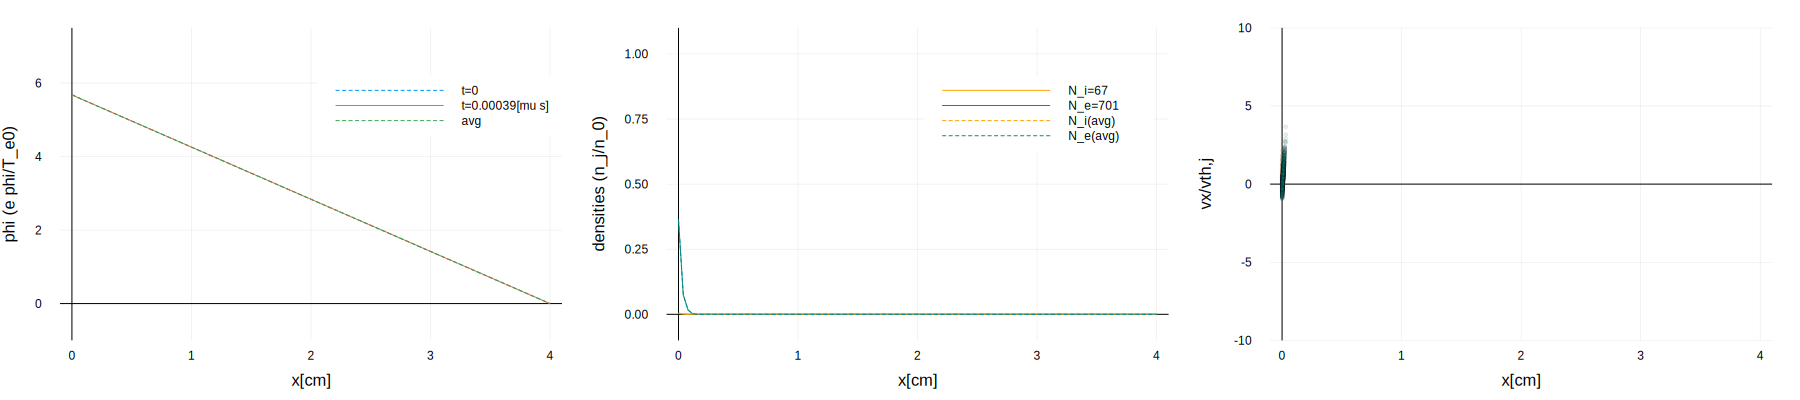

In [13]:
plot_summary(
        3,phi0,
        grid,Simulation_Parameters,units,
        Fields_struct,electrons,ions,  
        avg_field_struct
    )

In [ ]:
if(true)
    anim = @animate for i in 1:N_steps
        #> Inject new particles
        Ne_current=electrons.number_particles
        Ni_current=ions.number_particles
        Inject_Particles!(ions,electrons,Simulation_Parameters)
        Ne_post_injection=electrons.number_particles
        Ni_post_injection=ions.number_particles
    
        #> Calculaute potential
        Calculate_Electrostatic_Potential(
            Fields_struct,Poisson_struct,ions,electrons,grid,Simulation_Parameters,units
            );
        
        #> Calculuate fields on particles
        Field_to_Particles!(Fields_struct,ions,electrons,grid)
        
        #> Push particles
        Push_Particles!(ions,electrons,grid,Simulation_Parameters)

        append!(potential_all, Fields_struct.phi);

        Ne_post_absorption=electrons.number_particles
        Ni_post_absorption=ions.number_particles

        append!(Ne_markers,[electrons.number_particles])
        append!(Ne_array,[length(electrons.particle)])
        append!(Ne_injected,[Ne_post_injection-Ne_current])
        append!(Ne_absorbed,[Ne_post_absorption-Ne_post_injection])
        append!(Ne_changed,[Ne_post_absorption-Ne_current])

        append!(Ni_markers,[ions.number_particles])
        append!(Ni_array,[length(ions.particle)])
        append!(Ni_injected,[Ni_post_injection-Ni_current])
        append!(Ni_absorbed,[Ni_post_absorption-Ni_post_injection])
        append!(Ni_changed,[Ni_post_absorption-Ni_current])

        append!(i_step,[i])
        plot_summary(
            i,phi0,
            grid,Simulation_Parameters,units,
            Fields_struct,electrons,ions, 
            avg_field_struct
        )
        end every N_skip
end

In [ ]:
if(true)
    fps=100
    gif(anim, "sheath_fps="*string(fps)*".gif", fps = fps)
end

In [ ]:
function plot_particle_tracking(
        i_step,N_array,N_markers,N_injected,N_absorbed,N_changed;
        N_limits=50
    )
    plot(
        plot(
            i_step[1,1:end],N_markers[1,1:end],
            label="particles"
        ),    
        plot(
            i_step[1,1:end],N_injected[1,1:end],
            label="injected"
        ),    
        layout=(1,2),
        size=(800,300)
    )

    plot!(
        sp=1,
        i_step[1,1:end],N_array[1,1:end],
        label="array size"
    )
    plot!(
        sp=1,
        xlabel="time-steps",
        frame=:zerolines,
        legend=:bottomright,foreground_color_legend = nothing,
        margin=20px
    )

    plot!(
        sp=2,
        i_step[1,1:end],N_absorbed[1,1:end],
        label="absorbed"
    )
    plot!(
        sp=2,
        i_step[1,1:end],N_changed[1,1:end],
        label="change"
    )   

    plot!(
        sp=2,
        ylim=(-N_limits,N_limits),
        frame=:zerolines,
        ylabel="N particles", xlabel="time-steps",
        #legend=:inside,
        foreground_color_legend = nothing,
        #legendfontsize=5,
        margin=20px
    )
end

In [ ]:
plot_particle_tracking(
    i_step,Ne_array,Ne_markers,Ne_injected,Ne_absorbed,Ne_changed,
    N_limits=200
)

In [ ]:
plot_particle_tracking(
    i_step,Ni_array,Ni_markers,Ni_injected,Ni_absorbed,Ni_changed,
    N_limits=200
)